In [2]:
# Distance matrixes

In [3]:
from datetime import timedelta
import pandas as pd
import json
import requests
import itertools
import numpy as np

from datetime import date, timedelta
import plotly.express as px
import datetime as dt

import math
import time

import haversine

%reload_ext autoreload
%autoreload 2

import plotly.graph_objects as go

import sys
sys.path.append('..')
from src.distance import get_haversine_distance, get_distance_aws
from src.co2 import co2_truck, co2_train
from src.cvrp_ortools import cvrp_ortools
from src.distance import get_waypoints_osrm
from src.data_matrix_dict_points import osrm_matrix
#from src.data_matrix_dict_points import create_dict_points, create_data_model
from src.data_matrix import create_data_model, create_dict_points, create_distance_matrix
from src.evaluation import evaluate_cvrp_haversine, evaluate_cvrp
from src.hub_allocation_heuristic import get_closest_dct, initial_solution, create_solution, evaluate_solution, co2_modell
from src.hub_allocation_heuristic import co2_combined, co2_rail, main_terminals

if duplicate customers exist: dict_points for unique customers; distance matrix for unique customers. Distance matrix to dataframe with customer names as index and columns. Then selecting customers and getting demand per livraison

In [4]:
# osrm only goes for 100x100 matrix

https://github.com/remisoulignac/scm_optim_problems/blob/main/SCM290-GreenVehicleRoutingProblem.ipynb

> only possibility to model green vrp in or-tools

https://stackoverflow.com/questions/74824521/vrp-arc-cost-based-on-current-vehicle-load-co2-emissions

In [5]:
def create_limited_dataset(df, dc, percentage):
    df_dc = df[df["Shipper name"]==dc]
    weight = df_dc.groupby(["Receiver name"])["Sender weight (kg)"].sum().reset_index().sort_values(by = "Sender weight (kg)", ascending=False)
    weight["Sender weight cum"] = weight["Sender weight (kg)"].cumsum()
    high_volume_clients = weight[weight["Sender weight cum"]<df_dc["Sender weight (kg)"].sum()*percentage]["Receiver name"]
    df_dc = df_dc[df_dc["Receiver name"].isin(high_volume_clients)]
    print(len(df_dc["Receiver name"].unique()))
    return df_dc

In [6]:
def df_distance_matrix(df):
    dict_points = create_dict_points(df, "Shipper name", "Shipper latitude", "Shipper longitude")       
    dict_points.update(create_dict_points(df, "Receiver name", "Receiver latitude", "Receiver longitude"))
    dict_points.update(dict_terminals)
    distance_matrix = osrm_matrix(list(dict_points.items()))
    df_distance_matrix = pd.DataFrame(distance_matrix, columns = list(dict_points.keys()), index = list(dict_points.keys()))
    return df_distance_matrix

In [7]:
def show_clients(df):
    df = df.groupby(['Shipper longitude','Shipper latitude', 'Receiver longitude', 'Receiver latitude','Receiver name', 'Shipper name']).sum().reset_index()
    fig = go.Figure()
    fig.add_trace(go.Scattermapbox(lat=df['Receiver latitude'].to_list(), lon=df['Receiver longitude'].to_list(), 
                                   mode = 'markers', marker = {'size': 8}, name = "Clients",
                                   customdata=df[["Receiver name", "Sender weight (kg)"]],
                                   hovertemplate='''<br>%{customdata[0]}: %{customdata[1]}kg<br>'''))
    fig.update_layout(margin={"r": 0, "t": 40, "l": 0, "b": 40}, mapbox={
                      'zoom': 4, "center": {'lat': df["Receiver latitude"].mean(), 'lon': df["Receiver longitude"].mean()}})
    fig.update_layout(mapbox_style="open-street-map", showlegend = False, height = 500)
    fig.show()

In [8]:
def remove_nan_distance_matrix(df, df_distance_matrix):
    df_distance_matrix_new = df_distance_matrix.dropna(thresh = df_distance_matrix.isna().sum()[0]+1, axis = 1).dropna(thresh = df_distance_matrix.isna().sum()[0]+1, axis =0)
    clients_to_remove = list(df_distance_matrix.columns.difference(df_distance_matrix_new.columns))
    print(clients_to_remove)
    return df_distance_matrix_new, clients_to_remove

# Data Import

In [9]:
# Shipment dataset
df = pd.read_csv('../data/processed/poc3.csv', parse_dates = ["Pickup date"])

df_clients = df[['Receiver longitude', 'Receiver latitude']].drop_duplicates().reset_index()
df_clients.index += 1
df_clients= df_clients.reset_index().drop(["index"], axis = 1).rename({"level_0":"Receiver name"}, axis = 1)
df_clients["Receiver name"] = "C"+df_clients["Receiver name"].astype(str)

df_dc = df[['Shipper longitude', 'Shipper latitude', "DC country"]].drop_duplicates().reset_index()
df_dc.index += 1
df_dc = df_dc.reset_index().drop(["index"], axis = 1).rename({"level_0":"Shipper name"}, axis = 1)
df_dc["Shipper name"] = "DC"+df_dc["Shipper name"].astype(str)

df = df[['Pickup date','Country', 'Sender weight (kg)','Shipper longitude','Shipper latitude', 'Receiver longitude', 'Receiver latitude']].merge(df_clients, on = ['Receiver longitude', 'Receiver latitude'], how = "left").merge(df_dc, on = ['Shipper longitude', 'Shipper latitude'], how = "left")

# limit to 17 tons per order
df = df[df["Sender weight (kg)"]<17000]

df = df.rename({"Pickup date": "Delivery date"}, axis = 1)

C:\Users\marle\AppData\Local\Temp\ipykernel_15496\3026297825.py:2: DtypeWarning: Columns (1,5,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/poc3.csv', parse_dates = ["Pickup date"])


In [10]:
# Terminals
df_terminal = pd.read_excel('../data/external/intermodal_terminals/rne_final_terminals.xlsx').drop("id", axis = 1).reset_index(drop=True)
df_terminal.index = df_terminal.index + 1
df_terminal = df_terminal.reset_index(names='id')
df_terminal["id"] = "T" + df_terminal["id"].astype(str)
dict_terminals = create_dict_points(df_terminal, "id", "latitude", "longitude")

In [11]:
dict_points = create_dict_points(df, "Shipper name", "Shipper latitude", "Shipper longitude") 
dict_points.update(create_dict_points(df, "Receiver name", "Receiver latitude", "Receiver longitude"))
dict_points.update(dict_terminals)

In [12]:
f = open("dict_terminals.json")

In [13]:
import json
with open("dict_points.json", "w") as fp:
    json.dump(dict_points , fp)

In [14]:
json.load(f)

{'T1': [43.940029, 4.792082],
 'T2': [44.792583, -0.547815],
 'T3': [43.486462, -1.424943],
 'T4': [48.898636, 2.462777],
 'T5': [47.297089, -2.157143],
 'T6': [45.692131, 4.915366],
 'T7': [48.580566, 7.788796],
 'T8': [42.52322, 2.814462],
 'T9': [50.449467, 2.982361],
 'T10': [47.254944, 5.019372]}

In [15]:
# to do umbennen von dcs and terminals

## Data Exploration

In [16]:
df_dc2 = create_limited_dataset(df, "DC2", 0.8)
print(df_dc2.shape)
df_dc3 = create_limited_dataset(df, "DC3", 0.8)
print(df_dc3.shape)

106
(52550, 10)
118
(26110, 10)


In [17]:
dict_points = create_dict_points(df_dc2, "Shipper name", "Shipper latitude", "Shipper longitude") 
dict_points.update(create_dict_points(df_dc2, "Receiver name", "Receiver latitude", "Receiver longitude"))
dict_points.update(dict_terminals)
with open("dict_points.json", "w") as fp:
    json.dump(dict_points , fp)

In [18]:
#show_clients(df_dc3)

In [19]:
clients_to_remove = ["C840", "C986", "C808", "C11702"]

In [20]:
df_dc2 = df_dc2[~df_dc2["Receiver name"].isin(clients_to_remove)]
df_dc3 = df_dc3[~df_dc3["Receiver name"].isin(clients_to_remove)]

### Distance Matrix

In [21]:
df_distance_matrix_dc2 = df_distance_matrix(df_dc2)
df_distance_matrix_dc3 = df_distance_matrix(df_dc3)

1
2
1
2


In [22]:
df_distance_matrix_dc2, clients_to_remove_dc2 = remove_nan_distance_matrix(df_dc2, df_distance_matrix_dc2)
df_distance_matrix_dc3, clients_to_remove_dc3 = remove_nan_distance_matrix(df_dc3, df_distance_matrix_dc3)

[]
[]


In [23]:
for i in clients_to_remove_dc2:
    clients_to_remove.append(i)
for i in clients_to_remove_dc3:
    clients_to_remove.append(i)

In [24]:
df_dc2 = df_dc2[~df_dc2["Receiver name"].isin(clients_to_remove)]
df_dc3 = df_dc3[~df_dc3["Receiver name"].isin(clients_to_remove)]

In [25]:
#show_clients(df_dc2)

In [154]:
list_solution, closest_dct, dict_main_teerm = main_terminals(df_dc2, dict_terminals, df_distance_matrix_dc2, "DC2")

C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:490: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(closest_dct)


In [155]:
dict_main_teerm

{'T4-T1': [835.892558, 10, 86755.94, 795956.72, 776291.8],
 'T4-T2': [763.8716259999999, 10, 137557.93000000002, 592292.97, 627281.3],
 'T4-T3': [13.860373000000001, 1, 144364.5, 869348.4, 814151.5],
 'T4-T4': [1511.184087, 20, 99117.35500000001, 124529.155, 106307.4],
 'T4-T5': [1536.3288650000002, 16, 131250.54375, 391771.92500000005, 402176.8],
 'T4-T6': [1726.855506, 28, 84891.86785714285, 574146.4035714285, 561801.8],
 'T4-T7': [561.058659, 11, 108971.43636363637, 531532.7818181819, 590244.7],
 'T4-T8': [302.16131299999995, 2, 131797.4, 799630.3, 896050.0],
 'T4-T9': [639.551057, 4, 45551.875, 266899.275, 288705.3],
 'T4-T10': [46.074051999999995,
  3,
  38194.36666666667,
  424208.43333333335,
  403856.5]}

In [130]:
df_processing_time = df_dc2.groupby(["Receiver name", "Receiver latitude", "Receiver longitude", "Shipper name", "Shipper longitude", "Shipper latitude"]).sum().reset_index()
df_processing_time["Sender weight (kg)"] = 200
df_processing_time["Delivery date"] = list_mondays[2]

C:\Users\marle\AppData\Local\Temp\ipykernel_15496\1190774474.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_processing_time = df_dc2.groupby(["Receiver name", "Receiver latitude", "Receiver longitude", "Shipper name", "Shipper longitude", "Shipper latitude"]).sum().reset_index()


In [134]:
df_results_processing_time = pd.DataFrame(columns = ["date from", "date to", "co2 road", "distance road", "routes road", "processing time road","co2 railroad", "distance railroad", "terminal allocation", "routes railroad", "processing time railroad"])
for i in range(len(list_solution)):
    df_results_processing_time = df_results_processing_time.append(co2_modell(df_processing_time[df_processing_time["Receiver name"].isin(list_solution[i])],                                                                           df_distance_matrix_dc2, dict_terminals, list_mondays[1], list_mondays[2], country = "france"), ignore_index=True)

C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:255: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_test = df[(df["Delivery date"]>=pd.to_datetime(date_from))&(df["Delivery date"]<=pd.to_datetime(date_to))]


(10, 8)
0-0: 1455.170620356131 kg Co2 with 2000 and 1994612
only truck:  1455.170620356131


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


0-0: 722.1387942740062 kg Co2 with 2000 and 991889
T1 Container 0: 79.81525666137841 kg Co2 with 2000 and 106308
T1 co2 prehaul 79.81525666137841
T1 co2 endhaul 722.1387942740062
CO2 truck 801.9540509353845
Co2 train 181.0975841239688
Co2 transshipment 0.6776000000000001
T1: 181.0975841239688 kg Co2 with 2000, 669410.0, and 1
T1: 0.33880000000000005 kg Co2 for 1 container
CO2 rail 181.7751841239688
railroad:  983.7292350593534
Processing time: 1.296875
(10, 8)


C:\Users\marle\AppData\Local\Temp\ipykernel_15496\2127193313.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_processing_time = df_results_processing_time.append(co2_modell(df_processing_time[df_processing_time["Receiver name"].isin(list_solution[i])],
C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:255: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_test = df[(df["Delivery date"]>=pd.to_datetime(date_from))&(df["Delivery date"]<=pd.to_datetime(date_to))]


0-0: 1221.1925387300332 kg Co2 with 2000 and 1671090
only truck:  1221.1925387300332


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


0-0: 638.6405671765759 kg Co2 with 2000 and 881613
T2 Container 0: 79.81525666137841 kg Co2 with 2000 and 106308
T2 co2 prehaul 79.81525666137841
T2 co2 endhaul 638.6405671765759
CO2 truck 718.4558238379543
Co2 train 161.5191013360636
Co2 transshipment 0.6776000000000001
T2: 161.5191013360636 kg Co2 with 2000, 597040.0, and 1
T2: 0.33880000000000005 kg Co2 for 1 container
CO2 rail 162.19670133606363
railroad:  880.6525251740179
Processing time: 1.4375
(1, 8)


C:\Users\marle\AppData\Local\Temp\ipykernel_15496\2127193313.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_processing_time = df_results_processing_time.append(co2_modell(df_processing_time[df_processing_time["Receiver name"].isin(list_solution[i])],
C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:255: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_test = df[(df["Delivery date"]>=pd.to_datetime(date_from))&(df["Delivery date"]<=pd.to_datetime(date_to))]


0-0: 1240.5101554069638 kg Co2 with 200 and 1738150
only truck:  1240.5101554069638


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


0-0: 206.47524353826677 kg Co2 with 200 and 289303
T3 Container 0: 76.07906185037274 kg Co2 with 200 and 106308
T3 co2 prehaul 76.07906185037274
T3 co2 endhaul 206.47524353826677
CO2 truck 282.5543053886395
Co2 train 213.258718498959
Co2 transshipment 0.6776000000000001
T3: 213.258718498959 kg Co2 with 200, 794200.0, and 1
T3: 0.33880000000000005 kg Co2 for 1 container
CO2 rail 213.93631849895903
railroad:  496.49062388759853
Processing time: 1.625
(20, 8)


C:\Users\marle\AppData\Local\Temp\ipykernel_15496\2127193313.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_processing_time = df_results_processing_time.append(co2_modell(df_processing_time[df_processing_time["Receiver name"].isin(list_solution[i])],
C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:255: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_test = df[(df["Delivery date"]>=pd.to_datetime(date_from))&(df["Delivery date"]<=pd.to_datetime(date_to))]


0-0: 958.5511505612335 kg Co2 with 4000 and 1295173
only truck:  958.5511505612335


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


0-0: 958.5511505612335 kg Co2 with 4000 and 1295173
T4 co2 allroad 958.5511505612335
CO2 truck 958.5511505612335
CO2 rail 0
railroad:  958.5511505612335
Processing time: 1.65625
(16, 8)


C:\Users\marle\AppData\Local\Temp\ipykernel_15496\2127193313.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_processing_time = df_results_processing_time.append(co2_modell(df_processing_time[df_processing_time["Receiver name"].isin(list_solution[i])],
C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:255: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_test = df[(df["Delivery date"]>=pd.to_datetime(date_from))&(df["Delivery date"]<=pd.to_datetime(date_to))]


0-0: 1135.2622945338078 kg Co2 with 3200 and 1531078
only truck:  1135.2622945338078


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


0-0: 797.1343557547304 kg Co2 with 3200 and 1075608
T5 Container 0: 82.30605320204887 kg Co2 with 3200 and 106308
T5 co2 prehaul 82.30605320204887
T5 co2 endhaul 797.1343557547304
CO2 truck 879.4404089567793
Co2 train 128.25164454411677
Co2 transshipment 0.6776000000000001
T5: 128.25164454411677 kg Co2 with 3200, 471730.0, and 1
T5: 0.33880000000000005 kg Co2 for 1 container
CO2 rail 128.92924454411678
railroad:  1008.369653500896
Processing time: 1.59375
(28, 8)


C:\Users\marle\AppData\Local\Temp\ipykernel_15496\2127193313.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_processing_time = df_results_processing_time.append(co2_modell(df_processing_time[df_processing_time["Receiver name"].isin(list_solution[i])],
C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:255: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_test = df[(df["Delivery date"]>=pd.to_datetime(date_from))&(df["Delivery date"]<=pd.to_datetime(date_to))]


0-0: 1454.1546016943926 kg Co2 with 5600 and 1893865
only truck:  1454.1546016943926


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


0-0: 922.3056664328082 kg Co2 with 5600 and 1213072
T6 Container 0: 87.28764628338979 kg Co2 with 5600 and 106308
T6 co2 prehaul 87.28764628338979
T6 co2 endhaul 922.3056664328082
CO2 truck 1009.5933127161979
Co2 train 123.00245813455031
Co2 transshipment 0.6776000000000001
T6: 123.00245813455031 kg Co2 with 5600, 448000.0, and 1
T6: 0.33880000000000005 kg Co2 for 1 container
CO2 rail 123.68005813455031
railroad:  1133.2733708507483
Processing time: 1.71875
(11, 8)


C:\Users\marle\AppData\Local\Temp\ipykernel_15496\2127193313.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_processing_time = df_results_processing_time.append(co2_modell(df_processing_time[df_processing_time["Receiver name"].isin(list_solution[i])],
C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:255: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_test = df[(df["Delivery date"]>=pd.to_datetime(date_from))&(df["Delivery date"]<=pd.to_datetime(date_to))]


0-0: 1103.335035002322 kg Co2 with 2200 and 1505242
only truck:  1103.335035002322


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


0-0: 516.56275676895 kg Co2 with 2200 and 702754
T7 Container 0: 80.23038941815682 kg Co2 with 2200 and 106308
T7 co2 prehaul 80.23038941815682
T7 co2 endhaul 516.56275676895
CO2 truck 596.7931461871068
Co2 train 134.24663404797818
Co2 transshipment 0.6776000000000001
T7: 134.24663404797818 kg Co2 with 2200, 495820.0, and 1
T7: 0.33880000000000005 kg Co2 for 1 container
CO2 rail 134.9242340479782
railroad:  731.717380235085
Processing time: 1.453125
(2, 8)


C:\Users\marle\AppData\Local\Temp\ipykernel_15496\2127193313.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_processing_time = df_results_processing_time.append(co2_modell(df_processing_time[df_processing_time["Receiver name"].isin(list_solution[i])],
C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:255: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_test = df[(df["Delivery date"]>=pd.to_datetime(date_from))&(df["Delivery date"]<=pd.to_datetime(date_to))]


0-0: 1304.7665228655321 kg Co2 with 400 and 1824117
only truck:  1304.7665228655321


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


0-0: 350.117476231307 kg Co2 with 400 and 490396
T8 Container 0: 76.49419460715113 kg Co2 with 400 and 106308
T8 co2 prehaul 76.49419460715113
T8 co2 endhaul 350.117476231307
CO2 truck 426.61167083845817
Co2 train 256.48105085658784
Co2 transshipment 0.6776000000000001
T8: 256.48105085658784 kg Co2 with 400, 954370.0, and 1
T8: 0.33880000000000005 kg Co2 for 1 container
CO2 rail 257.1586508565878
railroad:  683.770321695046
Processing time: 1.203125
(4, 8)


C:\Users\marle\AppData\Local\Temp\ipykernel_15496\2127193313.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_processing_time = df_results_processing_time.append(co2_modell(df_processing_time[df_processing_time["Receiver name"].isin(list_solution[i])],
C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:255: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_test = df[(df["Delivery date"]>=pd.to_datetime(date_from))&(df["Delivery date"]<=pd.to_datetime(date_to))]


0-0: 441.8030070167004 kg Co2 with 800 and 614361
only truck:  441.8030070167004


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


0-0: 122.99995886262363 kg Co2 with 800 and 171770
T9 Container 0: 77.32446012070797 kg Co2 with 800 and 106308
T9 co2 prehaul 77.32446012070797
T9 co2 endhaul 122.99995886262363
CO2 truck 200.3244189833316
Co2 train 53.63095421238681
Co2 transshipment 0.6776000000000001
T9: 53.63095421238681 kg Co2 with 800, 199230.0, and 1
T9: 0.33880000000000005 kg Co2 for 1 container
CO2 rail 54.30855421238681
railroad:  254.63297319571842
Processing time: 1.4375
(3, 8)


C:\Users\marle\AppData\Local\Temp\ipykernel_15496\2127193313.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_processing_time = df_results_processing_time.append(co2_modell(df_processing_time[df_processing_time["Receiver name"].isin(list_solution[i])],
C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:255: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_test = df[(df["Delivery date"]>=pd.to_datetime(date_from))&(df["Delivery date"]<=pd.to_datetime(date_to))]


0-0: 693.0076437396481 kg Co2 with 600 and 966643
only truck:  693.0076437396481


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


0-0: 147.9142152973948 kg Co2 with 600 and 206700
T10 Container 0: 76.90932736392955 kg Co2 with 600 and 106308
T10 co2 prehaul 76.90932736392955
T10 co2 endhaul 147.9142152973948
CO2 truck 224.82354266132435
Co2 train 82.73440129634632
Co2 transshipment 0.6776000000000001
T10: 82.73440129634632 kg Co2 with 600, 307600.0, and 1
T10: 0.33880000000000005 kg Co2 for 1 container
CO2 rail 83.41200129634632
railroad:  308.23554395767064
Processing time: 1.640625


C:\Users\marle\AppData\Local\Temp\ipykernel_15496\2127193313.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_processing_time = df_results_processing_time.append(co2_modell(df_processing_time[df_processing_time["Receiver name"].isin(list_solution[i])],


In [135]:
df_results_processing_time["ratio"] = 1- (df_results_processing_time["co2 railroad"] /df_results_processing_time["co2 road"])

In [136]:
df_results_processing_time["ratio"]

0    0.323977
1    0.278859
2    0.599769
3    0.000000
4    0.111774
5    0.220665
6    0.336813
7    0.475944
8    0.423650
9    0.555221
Name: ratio, dtype: float64

In [140]:
df_matrix = pd.DataFrame(dict_main_teerm).T

In [148]:
df_matrix["Ratio"] = df_results_processing_time["ratio"].to_list()

In [149]:
df_matrix

0     1              2              3     Ratio
T4-T1    835.892558  10.0   86755.940000  795956.720000  0.323977
T4-T2    763.871626  10.0  137557.930000  592292.970000  0.278859
T4-T3     13.860373   1.0  144364.500000  869348.400000  0.599769
T4-T4   1511.184087  20.0   99117.355000  124529.155000  0.000000
T4-T5   1536.328865  16.0  131250.543750  391771.925000  0.111774
T4-T6   1726.855506  28.0   84891.867857  574146.403571  0.220665
T4-T7    561.058659  11.0  108971.436364  531532.781818  0.336813
T4-T8    302.161313   2.0  131797.400000  799630.300000  0.475944
T4-T9    639.551057   4.0   45551.875000  266899.275000  0.423650
T4-T10    46.074052   3.0   38194.366667  424208.433333  0.555221

In [157]:
df_matrix = pd.read_excel("matrix_analysis.xlsx")

In [156]:
df_matrix.to_excel("matrix_analysis.xlsx")

In [142]:
import seaborn as sb

              0         1         2         3         4     Ratio
0      1.000000  0.920810  0.055108 -0.296972 -0.298616 -0.923712
1      0.920810  1.000000  0.012984 -0.188492 -0.209013 -0.808465
2      0.055108  0.012984  1.000000  0.578626  0.625034 -0.192766
3     -0.296972 -0.188492  0.578626  1.000000  0.974877  0.321850
4     -0.298616 -0.209013  0.625034  0.974877  1.000000  0.282202
Ratio -0.923712 -0.808465 -0.192766  0.321850  0.282202  1.000000


C:\Users\marle\AppData\Local\Temp\ipykernel_15496\4048515356.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df_matrix.corr())
C:\Users\marle\AppData\Local\Temp\ipykernel_15496\4048515356.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sb.heatmap(df_matrix.corr(), cmap="YlGnBu", annot=True)


AttributeError: 'Axes' object has no attribute 'show'

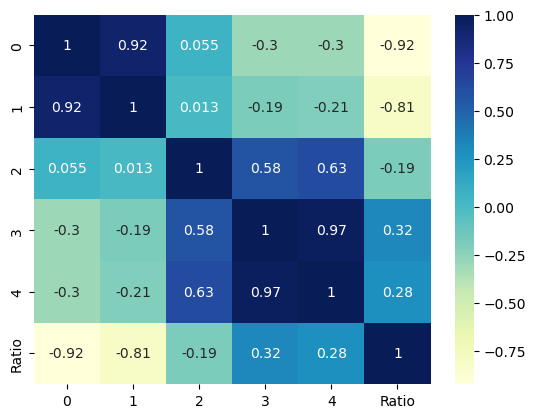

In [158]:
print(df_matrix.corr())
  
# plotting correlation heatmap
dataplot = sb.heatmap(df_matrix.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
dataplot.show()

In [186]:
def create_solution_150(df, dict_terminals, df_distance_matrix, dc):
    distances = df_distance_matrix.copy()[list(dict_terminals.keys())].drop(list(dict_terminals.keys()))
    distances['Dminidx'] = distances.idxmin(axis=1)
    distances['Dmin'] = distances.min(axis=1)
    closest_dct = distances.loc[dc]['Dminidx']
    closest_dct_distance = distances.loc[dc]['Dmin']
    # 150 km Rule
    distances["Dminidx"] = np.where(distances["Dmin"] > 150000, closest_dct, distances["Dminidx"])
    
    # 20% Rule
    df_distances = pd.read_excel("../data/external/intermodal_terminals/rne_terminals_distances.xlsx")
    df_distances["id_x"]="T" + (df_distances[f"facilityId_x"]+1).astype(str)
    df_distances["Dminidx"]="T" + (df_distances[f"facilityId_y"]+1).astype(str)
    distances = distances.merge(df_distances[df_distances["id_x"] == closest_dct][["Dminidx","Distance"]], on=["Dminidx"], how = "left")
    distances["Distance"] = distances["Distance"].fillna(0)
    distances["Travel distance"] = distances["Dmin"] + distances["Distance"]
    distances["Travel distance"] = distances["Travel distance"] + closest_dct_distance
    
    return distances, closest_dct, closest_dct_distance

    distances = distances.drop(dc)
    list_solution = []
    for i in dict_terminals.keys():
        list_solution.append(distances[distances["Dminidx"]==i].reset_index()["index"].to_list())

In [187]:
distances, closest_dct, closest_dct_distance =create_solution_150(df_dc2, dict_terminals, df_distance_matrix_dc2, "DC2")

C:\Users\marle\AppData\Local\Temp\ipykernel_15496\3543266764.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U2')) -> None

In [183]:
distances

T1        T2         T3        T4         T5        T6        T7  \
0    776291.8  627281.3   814151.5  106307.4   402176.8  561801.8  590244.7   
1     95509.3  631080.6   684310.7  774217.5  1038318.4  300953.5  799807.3   
2    634891.5  907443.2  1094313.5  341561.8   812354.8  420401.5  172619.8   
3    707986.1  961559.4  1148429.6  477410.3   907134.6  489972.2   14642.5   
4    701104.4  590969.4   777839.6   23883.3   436063.4  486614.5  510799.8   
..        ...       ...        ...       ...        ...       ...       ...   
101  351834.8  219698.7   316046.8  667923.4   626936.5  556291.9  954280.6   
102  505096.7  281135.1   468005.3  508919.0   471716.4  292177.9  700056.7   
103  585114.4   20781.5   194657.1  590869.5   406193.1  561483.8  969362.6   
104  228784.3  536755.3   723625.5  536461.9   719910.6   63198.0  562037.6   
105  242516.4  572909.7   759780.0  474461.5   756065.1   24502.6  488046.9   

           T8        T9       T10 Dminidx      Dmin  Distance  Travel distance  
0    896050.0  288705.3  403856.5      T4  106307.4      0.00        106307.40  
1    328055.2  968881.1  486938.0      T1   95509.3    669.41         96178.71  
2    878416.0  385412.5  228604.4      T4  172619.8      0.00        172619.80  
3    951510.6  521261.0  328529.8      T7   14642.5    495.82         15138.32  
4    872244.1  201907.4  328669.1      T4   23883.3      0.00         23883.30  
..        ...       ...       ...     ...       ...       ...              ...  
101  246713.9  853159.4  643241.8      T4  219698.7      0.00        219698.70  
102  508386.9  694155.0  389017.9      T4  281135.1      0.00        281135.10  
103  479993.5  776105.5  658323.8      T2   20781.5    597.04         21378.54  
104  472308.8  731125.5  249182.5      T6   63198.0    448.00         63646.00  
105  486040.9  669125.1  187182.0      T6   24502.6    448.00         24950.60  

[106 rows x 14 columns]

In [166]:
closest_dct_distance

106307.4

### List for range of days

In [98]:
def all_mondays(year):
    mondays = []
    first_day = date(year, 1, 1)
    if first_day.weekday() == 0:
        d = first_day
    else:
        d = first_day + timedelta(days = 7 - first_day.weekday())
    while d.year == year:
        mondays.append(d)
        d += timedelta(days = 7)
    return mondays

def all_wednesdays(year):
    wednesdays = []
    first_day = date(year, 1, 1)
    start_not_found = True
    while start_not_found:
        if first_day.weekday() == 2:
            d = first_day
            start_not_found = False
        else:
            first_day += timedelta(days = 1)
    while d.year == year:
        wednesdays.append(d)
        d += timedelta(days = 7)
    return wednesdays

def all_fridays(year):
    fridays = []
    first_day = date(year, 1, 1)
    start_not_found = True
    while start_not_found:
        if first_day.weekday() == 4:
            d = first_day
            start_not_found = False
        else:
            first_day += timedelta(days = 1)
    while d.year == year:
        fridays.append(d)
        d += timedelta(days = 7)
    return fridays

In [99]:
import datetime, calendar
year = 2022
month = 1
num_days = calendar.monthrange(year, month)[1]
list_days = [datetime.date(year, month, day) for day in range(1, num_days+1)]
list_mondays = all_mondays(2022)
list_wednesdays = all_wednesdays(2022)
list_fridays = all_fridays(2022)
list_bi_daily = []
for y in range(len(list_mondays)):
    a = list_mondays[y]
    b = list_wednesdays[y]
    c = list_fridays[y]
    temp = [a,b,c]
    list_bi_daily.extend(temp)

In [100]:
list_months = []
for i in range(1,13):
    #print(i)
    d = date(year, i, 1)
    list_months.append(d)

# Application of Decision Support Tool

In [ ]:
# Done: Comparison between Einbindung von Zug für jedes Terminal

In [42]:
df_test = df_dc2[(df_dc2["Delivery date"]>="2022-01-03")&(df_dc2["Delivery date"]<="2022-01-10")]
closest_dct = get_closest_dct(df_test, dict_terminals)
list_solution_dc2 = create_solution(df_test, dict_terminals, closest_dct)

C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


In [43]:
df_test = df_dc3[(df_dc3["Delivery date"]>="2022-01-03")&(df_dc3["Delivery date"]<="2022-01-10")]
closest_dct = get_closest_dct(df_test, dict_terminals)
list_solution = create_solution(df_test, dict_terminals, closest_dct)

C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


In [44]:
list_solution[0]+list_solution_dc2[0]

['C638',
 'C677',
 'C695',
 'C699',
 'C906',
 'C1187',
 'C991',
 'C818',
 'C2172',
 'C623',
 'C677',
 'C818',
 'C906',
 'C638',
 'C987',
 'C991',
 'C695',
 'C1187',
 'C1677']

In [45]:
from src.hub_allocation_improvement import evaluate_all_road, evaluate_with_train, evaluate_solution_drop

In [46]:
evaluate_solution_drop(df_test, list_solution, dict_terminals, closest_dct, df_distance_matrix_dc2)

TypeError: evaluate_solution_drop() missing 2 required positional arguments: 'power' and 'country'

> Zug muss eigentlich hin und leer zurück fahren

In [ ]:
df_eval = df_dc2.iloc[1:5]

In [ ]:
df_eval

In [ ]:
np.array(df_distance_matrix(df_eval))

In [ ]:
np.ceil(np.array(df_distance_matrix(df_eval))).astype(int)

In [ ]:
df_distance_matrix_dc2["C744"].loc["T6"]

In [ ]:
df_distance_matrix_dc2["T6"].loc["C744"]

In [ ]:
df_eval

In [ ]:
# daily
t = time.process_time()
df_results_daily = pd.DataFrame(columns = ["date from", "date to", "co2 road", "distance road", "routes road", "processing time road","co2 railroad", "distance railroad", "terminal allocation", "routes railroad", "processing time railroad"])
for i in range(1,len(list_days[:4])):
    print(i)
    df_results_daily = df_results_daily.append(co2_modell(df_eval, df_distance_matrix_dc2, dict_terminals, list_days[i-1], list_days[i], "normal"), ignore_index=True)
elapsed_time = time.process_time() - t
print("Processing time:", elapsed_time)

In [ ]:
df_results_daily["routes railroad"].iloc[0]

In [ ]:
df_results_daily

In [ ]:
import seaborn as sns
color = sns.color_palette().as_hex()

In [ ]:
# Graph with exact waypoints
dict_routes = df_results_daily["routes railroad"].iloc[0]
fig = go.Figure()
# für alle terminals
dc = list(dict_points.keys())[0]
for i in dict_routes:
    routes_terminal = dict_routes[i]
    for j in range(len(routes_terminal)):
        if routes_terminal[j]:
            waypoints = get_waypoints_osrm([dict_points[node][::-1] for node in routes_terminal[j]])["geometry"]["coordinates"]
            lat = [coords[1] for coords in waypoints]
            lon = [coords[0] for coords in waypoints]
            if i != closest_dct:
                waypoints = get_waypoints_osrm([dict_points[dc][::-1],dict_points[closest_dct][::-1]])["geometry"]["coordinates"]
                lat = [coords[1] for coords in waypoints]+lat
                lon = [coords[0] for coords in waypoints]+lon
                fig.add_trace(go.Scattermapbox(lat=lat, lon=lon, name = f"Railroad {j+1} over {routes_terminal[j][0]}", mode = 'lines', marker = {'size': 10, "color":color[list(dict_terminals.keys()).index(i)]}))
            else:
                fig.add_trace(go.Scattermapbox(lat=lat, lon=lon, name = f"Truck {j+1} directly from {routes_terminal[j][0]}", mode = 'lines', marker = {'size': 10, "color":color[list(dict_terminals.keys()).index(i)]}))
fig.add_trace(go.Scattermapbox(lat=[list(dict_points.values())[0][0]], lon=[list(dict_points.values())[0][1]], mode = 'markers', name = "DC", marker = {'size': 10, 'color': "red"}))
dict_clients = create_dict_points(df_eval, "Receiver name", "Receiver latitude", "Receiver longitude")
fig.add_trace(go.Scattermapbox(lat=[i[0] for i in list(dict_clients.values())], lon=[i[1] for i in list(dict_clients.values())], name = "Clients", mode = 'markers', customdata=list(dict_points.keys())[1:], hovertemplate='''<br>%{customdata}<br>''', marker = {'size': 10,"color": "orange"}))
fig.add_trace(go.Scattermapbox(lat=[i[0] for i in list(dict_terminals.values())], lon=[i[1] for i in list(dict_terminals.values())], name = "Terminals", mode = 'markers', customdata=list(dict_terminals.keys()), hovertemplate='''<br>%{customdata}<br>''', marker = {'size': 10, "color": "blue"}))
fig.update_layout(mapbox_style="open-street-map", height = 600, width = 800)
fig.show()

> Irgendwie noch den Auslastungsgrad mit einbeziehen

***

# Application of Decision Support Tool

1. Base scenario: Rail mandatory
2. Scenario: Allowing allroad if rail is not better
3. Scenario: Only one route
4. Scenario: Combining the two DC's

In [28]:
date_from = "2022-01-03"
date_to = "2022-01-04"
df_test = df_dc2[(df_dc2["Delivery date"]>=date_from)&(df_dc2["Delivery date"]<=date_to)]
closest_dct = get_closest_dct(df_test, dict_terminals)
list_solution_dc2 = create_solution(df_test, dict_terminals, closest_dct)

C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


In [29]:
df_dc2_eval = df_test[df_test["Receiver name"].isin(list_solution_dc2[3]+list_solution_dc2[4])] 

In [30]:
df_dc2_eval_small = df_test[df_test["Receiver name"].isin(['C780',
 'C842',
 'C635',
 'C702',
 'C994',
 'C722',
 'C725',
 'C741',
 'C771',
 'C774',
 'C778',
 'C820',
 'C838',
 'C873',
 'C892'])]

## 1. Base scenario

### Daily

In [31]:
from src.plots import graph_solution, plot_railroad

In [32]:
df_dc2

Delivery date Country  Sender weight (kg)  Shipper longitude  \
1117   2022-01-03 07:58:00  France             702.000           1.179094   
1270   2022-01-03 11:59:00  France              13.976           1.179094   
1273   2022-01-03 11:59:00  France              63.000           1.179094   
1275   2022-01-03 11:59:00  France              22.001           1.179094   
1279   2022-01-03 11:59:00  France              64.000           1.179094   
...                    ...     ...                 ...                ...   
491859 2022-12-30 18:02:00  France           16557.854           1.179094   
491860 2022-12-30 18:07:00  France            3342.139           1.179094   
491861 2022-12-30 18:07:00  France            1357.641           1.179094   
491862 2022-12-30 18:07:00  France            1040.999           1.179094   
491863 2022-12-30 18:34:00  France            5215.852           1.179094   

        Shipper latitude  Receiver longitude  Receiver latitude Receiver name  \
1117           49.005514            5.386984          43.484334          C623   
1270           49.005514            6.173715          48.744187          C744   
1273           49.005514            7.646659          48.560105          C757   
1275           49.005514            2.227839          48.927546          C731   
1279           49.005514            5.005212          45.664623          C761   
...                  ...                 ...                ...           ...   
491859         49.005514            5.282961          45.855417          C774   
491860         49.005514            0.624121          47.411070          C780   
491861         49.005514           -1.662835          47.644423          C637   
491862         49.005514           -0.920033          47.037756          C698   
491863         49.005514            3.254816          49.852738          C704   

       Shipper name DC country  
1117            DC2     France  
1270            DC2     France  
1273            DC2     France  
1275            DC2     France  
1279            DC2     France  
...             ...        ...  
491859          DC2     France  
491860          DC2     France  
491861          DC2     France  
491862          DC2     France  
491863          DC2     France  

[51910 rows x 10 columns]

In [33]:
# daily
dict_results = co2_modell(df_dc2_eval, df_distance_matrix_dc2, dict_terminals, date_from, date_to)

(31, 10)
0-0: 1484.2380837260434 kg Co2 with 5951 and 1934261
only truck:  1484.2380837260434


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


0-0: 683.4294076022848 kg Co2 with 552 and 952363
T4 co2 allroad 683.4294076022848
0-0: 747.628712225449 kg Co2 with 5399 and 1028331
T5 Container 0: 86.88889881652142 kg Co2 with 5407.893999999999 and 106308
T5 co2 prehaul 86.88889881652142
T5 co2 endhaul 747.628712225449
CO2 truck 1517.9470186442552
Co2 train 129.4164006658663
Co2 transshipment 0.6776000000000001
T5: 129.4164006658663 kg Co2 with 5407.893999999999, 471730.0, and 1
T5: 0.33880000000000005 kg Co2 for 1 container
CO2 rail 130.0940006658663
railroad:  1648.0410193101216
Processing time: 2.90625


In [34]:
dict_results

{'date from': Timestamp('2022-01-03 11:59:00'),
 'date to': Timestamp('2022-01-03 17:13:00'),
 'co2 road': 1484.2380837260434,
 'distance road': 1934261,
 'routes road': [['DC2',
   'C741',
   'C702',
   'C787',
   'C790',
   'C1014',
   'C1014',
   'C921',
   'C864',
   'C809',
   'C637',
   'C637',
   'C720',
   'C720',
   'C720',
   'C720',
   'C716',
   'C835',
   'C698',
   'C698',
   'C708',
   'C780',
   'C780',
   'C780',
   'C725',
   'C994',
   'C782',
   'C782',
   'C782',
   'C635',
   'C1117',
   'C731',
   'DC2']],
 'processing time road': 0.953125,
 'co2 railroad': 1648.0410193101216,
 'distance railroad': 2558732.0,
 'terminal allocation': [[],
  [],
  [],
  ['C731', 'C780', 'C782', 'C635', 'C702', 'C994', 'C741', 'C1117', 'C725'],
  ['C787',
   'C790',
   'C809',
   'C835',
   'C864',
   'C921',
   'C720',
   'C708',
   'C637',
   'C698',
   'C1014',
   'C716'],
  [],
  [],
  [],
  [],
  []],
 'routes railroad': {'T1': [[]],
  'T2': [[]],
  'T3': [[]],
  'T4': [['DC2',

In [35]:
plot_railroad(dict_points, dict_terminals, dict_results["routes railroad"], "T4", "DC2")

routes terminal ['DC2', 'C741', 'C702', 'C780', 'C780', 'C780', 'C725', 'C994', 'C782', 'C782', 'C782', 'C635', 'C1117', 'C731', 'DC2']
routes terminal ['T5', 'C720', 'C720', 'C720', 'C720', 'C835', 'C708', 'C698', 'C698', 'C716', 'C637', 'C637', 'C1014', 'C1014', 'C787', 'C790', 'C921', 'C864', 'C809', 'T5']


In [50]:
dict_routes = dict_results["routes railroad"]
waypoints_all = []
for i in dict_routes.keys():
        routes_terminal = dict_routes[i]
        for j in range(len(routes_terminal)):
            if routes_terminal[j]:
                waypoints = [dict_points[node] for node in routes_terminal[j]]
            else:
                waypoints = []
            waypoints_all.append(waypoints)

In [51]:
waypoints_all

[[],
 [],
 [],
 [[49.00551373, 1.179093518],
  [49.396776887518485, 1.113552887909436],
  [49.39927256438491, 0.2534923287516768],
  [47.411070017801165, 0.6241210366711698],
  [47.411070017801165, 0.6241210366711698],
  [47.411070017801165, 0.6241210366711698],
  [47.826073446197135, 1.673623253211009],
  [48.20493100593097, 3.267015993253807],
  [48.62450265338876, 2.356350511450959],
  [48.62450265338876, 2.356350511450959],
  [48.62450265338876, 2.356350511450959],
  [48.80403499528953, 2.632277013097081],
  [48.94482498473712, 2.310601026895739],
  [48.92754598470757, 2.227839036950769],
  [49.00551373, 1.179093518]],
 [[47.297089, -2.157143],
  [47.23423453961157, -1.6542563064403342],
  [47.23423453961157, -1.6542563064403342],
  [47.23423453961157, -1.6542563064403342],
  [47.23423453961157, -1.6542563064403342],
  [46.71785800099272, -1.3260380371129372],
  [46.91424026288908, -0.4672095034215028],
  [47.03775601789252, -0.9200329803489352],
  [47.03775601789252, -0.9200329803

In [54]:
graph_solution(df_dc2_eval, dict_results["routes railroad"], dict_terminals, closest_dct)

C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\plots.py:21: SyntaxWarning:

list indices must be integers or slices, not tuple; perhaps you missed a comma?

C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\plots.py:32: SyntaxWarning:

list indices must be integers or slices, not tuple; perhaps you missed a comma?



[[1.179093518, 49.00551373], [1.113552887909436, 49.396776887518485], [0.2534923287516768, 49.39927256438491], [0.6241210366711698, 47.411070017801165], [0.6241210366711698, 47.411070017801165], [0.6241210366711698, 47.411070017801165], [1.673623253211009, 47.826073446197135], [3.267015993253807, 48.20493100593097], [2.356350511450959, 48.62450265338876], [2.356350511450959, 48.62450265338876], [2.356350511450959, 48.62450265338876], [2.632277013097081, 48.80403499528953], [2.310601026895739, 48.94482498473712], [2.227839036950769, 48.92754598470757], [1.179093518, 49.00551373]]
[[1.179093518, 49.00551373], [2.462777, 48.898636], [-2.157143, 47.297089], [-1.6542563064403342, 47.23423453961157], [-1.6542563064403342, 47.23423453961157], [-1.6542563064403342, 47.23423453961157], [-1.6542563064403342, 47.23423453961157], [-1.3260380371129372, 46.71785800099272], [-0.4672095034215028, 46.91424026288908], [-0.9200329803489352, 47.03775601789252], [-0.9200329803489352, 47.03775601789252], [-

In [287]:
# daily, volume = 10
dict_results = co2_modell(df_dc2_eval, df_distance_matrix_dc2, dict_terminals, date_from, date_to, volume = 1)
graph_solution(df_dc2_eval, dict_results, dict_terminals, closest_dct)

(31, 10)
0-0: 1484.2380837260434 kg Co2 with 5951 and 1934261
only truck:  1484.2380837260434


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



0-0: 683.4294076022848 kg Co2 with 552 and 952363
T4 co2 allroad 683.4294076022848
0-0: 747.628712225449 kg Co2 with 5399 and 1028331
T5 Container 0: 86.88889881652142 kg Co2 with 5407.893999999999 and 106308
T5 co2 prehaul 86.88889881652142
T5 co2 endhaul 747.628712225449
CO2 truck 1517.9470186442552
Co2 train 129.4164006658663
Co2 transshipment 0.6776000000000001
T5: 129.4164006658663 kg Co2 with 5407.893999999999, 471730.0, and 1
T5: 0.33880000000000005 kg Co2 for 1 container
CO2 rail 130.0940006658663
railroad:  1648.0410193101216
Processing time: 2.40625


TypeError: object of type 'Timestamp' has no len()

### Sensi 4: 150km

In [289]:
from src.plots import graph_solution_with_radius
graph_solution_with_radius(df_dc2_eval, dict_results, dict_terminals, closest_dct)

> C947 muss all road delivered werden. Wie verändert sich die Co2 Emissionen?

In [ ]:
list_solution = [[],
                 [],
                 [],
                 ['C731', 'C780', 'C782', 'C635', 'C702', 'C994', 'C741', 'C1117', 'C725',"C947"],
                 [],
                 ['C761',
                  'C764',
                  'C771',
                  'C774',
                  'C778',
                  'C812',
                  'C820',
                  'C873',
                  'C891',
                  'C892',
                  #'C947',
                  'C1004',
                  'C1154',
                  'C1183'],
                 [],
                 [],
                 [],
                 []]

In [ ]:
from src.hub_allocation_heuristic import co2_evaluation
df_dc2_eval_new = df_dc2_eval[df_dc2_eval["Receiver name"].isin(list(itertools.chain(*dict_results["terminal allocation"])))]
dict_results_new = co2_evaluation(df_dc2_eval_new, df_distance_matrix_dc2, dict_terminals, list_solution)

In [288]:
from src.plots import graph_solution_with_radius
graph_solution_with_radius(df_dc2_eval_new, dict_results_new, dict_terminals, closest_dct)

NameError: name 'dict_results_new' is not defined

***

## Scenario 1: Using drop algorithm

In [ ]:
# vllt nochmal schauen, wie ich zeigen kann das terminals gedropped werden

### Daily

In [ ]:
# daily
t = time.process_time()
df_results_daily = pd.DataFrame(columns = ["date from", "date to", "co2 road", "distance road", "routes road", "processing time road","co2 railroad", "distance railroad", "terminal allocation", "routes railroad", "processing time railroad"])
for i in range(1,len(list_days[:20])):
    print(i)
    df_results_daily = df_results_daily.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_days[i-1], list_days[i], "drop"), ignore_index=True)
elapsed_time = time.process_time() - t
print("Processing time:", elapsed_time)

> Auffälligkeit: kaum unterscheid zwischen Rail and Railroad. Vielleicht sollten wir uns das nochmal anschauen.

### Monday, Wednesday, Friday

In [ ]:
# montag, mittwoch, freitag
t = time.process_time()
df_results_bi_daily = pd.DataFrame(columns = ["date from", "date to", "co2 road", "distance road", "routes road", "processing time road","co2 railroad", "distance railroad", "terminal allocation", "routes railroad", "processing time railroad"])
for i in range(1,len(list_bi_daily[:5])):
    df_results_bi_daily = df_results_bi_daily.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_bi_daily[i-1], list_bi_daily[i], "drop"), ignore_index=True)
elapsed_time = time.process_time() - t
print("Processing time:", elapsed_time)

> not always better. In some cases even worse. Vielleicht doch lohnenswert, anzuschauen wie es sich lohnt, wenn nur manche Terminals genutzt werden

### Weekly

In [ ]:
# weekly
t = time.process_time()
df_results_weekly_drop = pd.DataFrame(columns = ["date from", "date to", "co2 road", "distance road", "routes road", "processing time road","co2 railroad", "distance railroad", "terminal allocation", "routes railroad", "processing time railroad"])
for i in range(1,len(list_mondays[:2])):
    df_results_weekly_drop = df_results_weekly_drop.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_mondays[i-1], list_mondays[i], "drop"), ignore_index=True)
elapsed_time = time.process_time() - t
print("Processing time:", elapsed_time)

In [ ]:
df_results_weekly_drop

> Best solution we can get

***

## Scenario 2: Only one route open

In [ ]:
dict_terminals_one_route = {x: dict_terminals[x] for x in ["T4", "T6"]}

In [ ]:
# weekly
df_results_one_route = pd.DataFrame(columns = ["date from", "date to", "co2 road", "distance road", "routes road", "processing time road","co2 railroad", "distance railroad", "terminal allocation", "routes railroad", "processing time railroad"])
for i in range(1,len(list_mondays[:2])):
    df_results_one_route = df_results_one_route.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals_one_route, list_mondays[i-1], list_mondays[i]), ignore_index=True)
elapsed_time = time.process_time() - t
print("Processing time:", elapsed_time)

In [ ]:
df_results_one_route

***

## Scenario 3: Combining two DC's

### Daily

In [1]:
date_from = "2022-01-03"
date_to = "2022-01-04"
df_test = df_dc2[(df_dc2["Delivery date"]>=date_from)&(df_dc2["Delivery date"]<=date_to)]
closest_dct = get_closest_dct(df_test, dict_terminals)
list_solution_dc2 = create_solution(df_test, dict_terminals, closest_dct)
df_test = df_dc3[(df_dc3["Delivery date"]>=date_from)&(df_dc3["Delivery date"]<=date_to)]
closest_dct = get_closest_dct(df_test, dict_terminals)
list_solution = create_solution(df_test, dict_terminals, closest_dct)
df_dc2_eval = df_dc2[df_dc2["Receiver name"].isin(list_solution[0]+list_solution_dc2[0])]
df_dc3_eval = df_dc3[df_dc3["Receiver name"].isin(list_solution[0]+list_solution_dc2[0])]

NameError: name 'df_dc2' is not defined

In [105]:
columns = ["date from",
            "date to",
            "co2", 
            "distance", 
            "processing time",
            "df shape"]
df_results_combined = pd.DataFrame(columns = columns)
dcs = ["DC2", "DC3"]
dict_df = {"DC2": df_dc2, "DC3": df_dc3}
dict_df_distance_matrix = {"DC2": df_distance_matrix_dc2, "DC3": df_distance_matrix_dc3}
# Solving combined
dict_results = co2_combined(dcs, dict_df, dict_df_distance_matrix, dict_terminals, date_from, date_to)
df_results_combined = df_results_combined.append(pd.DataFrame(dict_results, index = ["combined"]))
#Solving seperate
for dc in dcs:
    dict_results = co2_rail(dict_df[dc], dict_df_distance_matrix[dc], dict_terminals,  date_from, date_to)
    df_results_combined = df_results_combined.append(pd.DataFrame(dict_results, index = [f"{dc} only"]))

['DC2', 'DC3']
DC2
550


C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


Bin number 0
  Items packed: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 76, 77, 84]
  Total weight: 13809.882000000001

Bin number 1
  Items packed: [68, 75, 78, 79, 80, 81, 82, 83, 87, 88, 89, 99, 113]
  Total weight: 13809.41

Bin number 2
  Items packed: [85, 86, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 163]
  Total weight: 13807.100000000002

Bin number 3
  Items packed: [154, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 17

Bin number 0
  Items packed: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91]
  Total weight: 13755.302999999996

Bin number 1
  Items packed: [72, 73, 87]
  Total weight: 9697.379


Number of bins used: 2
Time =  604  milliseconds
Bin number 0
  Items packed: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 66, 70]
  Total weight: 13809.614

Bin number 1
  Items packed: [57, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 9

C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


Bin number 0
  Items packed: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 55, 115]
  Total weight: 13809.816

Bin number 1
  Items packed: [48, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 88, 89, 90, 91, 150]
  Total weight: 13809.887000000002

Bin number 2
  Items packed: [80, 86, 87, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 142, 145]
  Total weight: 13809.168000000001

Bin number 3
  Items packed: [133, 135, 136, 137, 138, 139, 140, 141, 143, 144, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 1

T1
Co2 transshipment 0.6776000000000001
T2
Co2 transshipment 0.6776000000000001
T4
Co2 transshipment 2.0328
T5
Co2 transshipment 1.3552000000000002
T7
Co2 transshipment 0.6776000000000001
T8
Co2 transshipment 0.6776000000000001
T9
Co2 transshipment 0.6776000000000001
T10
Co2 transshipment 0.6776000000000001
co2 rail 141.99202476159803
1
12288
from 0 to 1
Distance from 0 to 1 0
Load 12288
from 1 to 2
Distance from 1 to 2 4984
Load 12288
from 2 to 3
Distance from 2 to 3 0
Load 12206
from 3 to 4
Distance from 3 to 4 0
Load 12171
from 4 to 5
Distance from 4 to 5 0
Load 12160
from 5 to 6
Distance from 5 to 6 0
Load 12054
from 6 to 7
Distance from 6 to 7 0
Load 12041
from 7 to 8
Distance from 7 to 8 0
Load 12015
from 8 to 9
Distance from 8 to 9 0
Load 11953
from 9 to 10
Distance from 9 to 10 0
Load 11799
from 10 to 11
Distance from 10 to 11 0
Load 11563
from 11 to 12
Distance from 11 to 12 0
Load 11496
from 12 to 13
Distance from 12 to 13 0
Load 11435
from 13 to 14
Distance from 13 to 14 0
L

10558
from 0 to 1
Distance from 0 to 1 0
Load 10558
from 1 to 2
Distance from 1 to 2 12469
Load 10558
from 2 to 3
Distance from 2 to 3 0
Load 10482
from 3 to 4
Distance from 3 to 4 12586
Load 10198
from 4 to 5
Distance from 4 to 5 0
Load 10009
from 5 to 6
Distance from 5 to 6 0
Load 9907
from 6 to 7
Distance from 6 to 7 0
Load 6834
from 7 to 8
Distance from 7 to 8 0
Load 6386
from 8 to 9
Distance from 8 to 9 0
Load 3955
from 9 to 10
Distance from 9 to 10 0
Load 3912
from 10 to 11
Distance from 10 to 11 0
Load 3877
from 11 to 12
Distance from 11 to 12 0
Load 3758
from 12 to 13
Distance from 12 to 13 0
Load 3709
from 13 to 14
Distance from 13 to 14 0
Load 3216
from 14 to 15
Distance from 14 to 15 0
Load 1391
from 15 to 16
Distance from 15 to 16 0
Load 158
from 16 to 17
Distance from 16 to 17 0
Load 92
from 17 to 18
Distance from 17 to 18 22973
Load 0
from 18 to 19
Distance from 18 to 19 0
Load 0
10558
from 0 to 1
Distance from 0 to 1 0
Load 10558
from 1 to 2
Distance from 1 to 2 22163
Lo

10008
from 0 to 1
Distance from 0 to 1 0
Load 10008
from 1 to 2
Distance from 1 to 2 89080
Load 10008
from 2 to 3
Distance from 2 to 3 0
Load 10003
from 3 to 4
Distance from 3 to 4 0
Load 9995
from 4 to 5
Distance from 4 to 5 0
Load 9969
from 5 to 6
Distance from 5 to 6 47611
Load 9906
from 6 to 7
Distance from 6 to 7 0
Load 9856
from 7 to 8
Distance from 7 to 8 0
Load 9677
from 8 to 9
Distance from 8 to 9 0
Load 9204
from 9 to 10
Distance from 9 to 10 18488
Load 9067
from 10 to 11
Distance from 10 to 11 0
Load 8760
from 11 to 12
Distance from 11 to 12 0
Load 8743
from 12 to 13
Distance from 12 to 13 0
Load 8314
from 13 to 14
Distance from 13 to 14 0
Load 8297
from 14 to 15
Distance from 14 to 15 2650
Load 8060
from 15 to 16
Distance from 15 to 16 0
Load 8010
from 16 to 17
Distance from 16 to 17 0
Load 7775
from 17 to 18
Distance from 17 to 18 0
Load 7594
from 18 to 19
Distance from 18 to 19 0
Load 7524
from 19 to 20
Distance from 19 to 20 0
Load 7509
from 20 to 21
Distance from 20 to 

13550
from 0 to 1
Distance from 0 to 1 0
Load 13550
from 1 to 2
Distance from 1 to 2 13564
Load 13550
from 2 to 3
Distance from 2 to 3 36211
Load 13540
from 3 to 4
Distance from 3 to 4 1728
Load 11299
from 4 to 5
Distance from 4 to 5 0
Load 6805
from 5 to 6
Distance from 5 to 6 0
Load 2757
from 6 to 7
Distance from 6 to 7 0
Load 265
from 7 to 8
Distance from 7 to 8 0
Load 103
from 8 to 9
Distance from 8 to 9 49727
Load 0
from 9 to 10
Distance from 9 to 10 0
Load 0
13550
from 0 to 1
Distance from 0 to 1 0
Load 13550
from 1 to 2
Distance from 1 to 2 49706
Load 13550
from 2 to 3
Distance from 2 to 3 0
Load 13447
from 3 to 4
Distance from 3 to 4 0
Load 13285
from 4 to 5
Distance from 4 to 5 0
Load 10793
from 5 to 6
Distance from 5 to 6 0
Load 6745
from 6 to 7
Distance from 6 to 7 1730
Load 2251
from 7 to 8
Distance from 7 to 8 36199
Load 10
from 8 to 9
Distance from 8 to 9 13960
Load 0
from 9 to 10
Distance from 9 to 10 0
Load 0
Tour [0, 22, 47, 149, 138, 53, 52, 29, 0] 85.54299535072583
1

5872
from 0 to 1
Distance from 0 to 1 0
Load 5872
from 1 to 2
Distance from 1 to 2 7368
Load 5872
from 2 to 3
Distance from 2 to 3 0
Load 5858
from 3 to 4
Distance from 3 to 4 0
Load 5825
from 4 to 5
Distance from 4 to 5 0
Load 5780
from 5 to 6
Distance from 5 to 6 0
Load 5769
from 6 to 7
Distance from 6 to 7 0
Load 5755
from 7 to 8
Distance from 7 to 8 0
Load 5711
from 8 to 9
Distance from 8 to 9 0
Load 5617
from 9 to 10
Distance from 9 to 10 0
Load 5572
from 10 to 11
Distance from 10 to 11 0
Load 5539
from 11 to 12
Distance from 11 to 12 0
Load 5461
from 12 to 13
Distance from 12 to 13 87338
Load 5397
from 13 to 14
Distance from 13 to 14 0
Load 5388
from 14 to 15
Distance from 14 to 15 0
Load 5376
from 15 to 16
Distance from 15 to 16 0
Load 5369
from 16 to 17
Distance from 16 to 17 0
Load 5363
from 17 to 18
Distance from 17 to 18 0
Load 5229
from 18 to 19
Distance from 18 to 19 0
Load 5221
from 19 to 20
Distance from 19 to 20 0
Load 5216
from 20 to 21
Distance from 20 to 21 0
Load 51

8932
from 0 to 1
Distance from 0 to 1 0
Load 8932
from 1 to 2
Distance from 1 to 2 25011
Load 8932
from 2 to 3
Distance from 2 to 3 0
Load 8880
from 3 to 4
Distance from 3 to 4 0
Load 8844
from 4 to 5
Distance from 4 to 5 0
Load 8665
from 5 to 6
Distance from 5 to 6 0
Load 8610
from 6 to 7
Distance from 6 to 7 226999
Load 7747
from 7 to 8
Distance from 7 to 8 0
Load 5353
from 8 to 9
Distance from 8 to 9 0
Load 4946
from 9 to 10
Distance from 9 to 10 0
Load 4846
from 10 to 11
Distance from 10 to 11 0
Load 4507
from 11 to 12
Distance from 11 to 12 0
Load 4502
from 12 to 13
Distance from 12 to 13 0
Load 4381
from 13 to 14
Distance from 13 to 14 0
Load 4375
from 14 to 15
Distance from 14 to 15 0
Load 4267
from 15 to 16
Distance from 15 to 16 0
Load 4254
from 16 to 17
Distance from 16 to 17 0
Load 3484
from 17 to 18
Distance from 17 to 18 0
Load 24
from 18 to 19
Distance from 18 to 19 0
Load 13
from 19 to 20
Distance from 19 to 20 238386
Load 0
from 20 to 21
Distance from 20 to 21 0
Load 0


826
from 0 to 1
Distance from 0 to 1 0
Load 826
from 1 to 2
Distance from 1 to 2 62414
Load 826
from 2 to 3
Distance from 2 to 3 70921
Load 793
from 3 to 4
Distance from 3 to 4 0
Load 753
from 4 to 5
Distance from 4 to 5 0
Load 182
from 5 to 6
Distance from 5 to 6 76104
Load 116
from 6 to 7
Distance from 6 to 7 0
Load 104
from 7 to 8
Distance from 7 to 8 0
Load 95
from 8 to 9
Distance from 8 to 9 0
Load 84
from 9 to 10
Distance from 9 to 10 0
Load 68
from 10 to 11
Distance from 10 to 11 0
Load 58
from 11 to 12
Distance from 11 to 12 0
Load 44
from 12 to 13
Distance from 12 to 13 0
Load 38
from 13 to 14
Distance from 13 to 14 27664
Load 17
from 14 to 15
Distance from 14 to 15 0
Load 12
from 15 to 16
Distance from 15 to 16 23990
Load 0
from 16 to 17
Distance from 16 to 17 0
Load 0
826
from 0 to 1
Distance from 0 to 1 0
Load 826
from 1 to 2
Distance from 1 to 2 24231
Load 826
from 2 to 3
Distance from 2 to 3 0
Load 814
from 3 to 4
Distance from 3 to 4 27705
Load 809
from 4 to 5
Distance f

C:\Users\marle\AppData\Local\Temp\ipykernel_23972\786857086.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_combined = df_results_combined.append(pd.DataFrame(dict_results, index = ["combined"]))
C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


12277
from 0 to 1
Distance from 0 to 1 0
Load 12277
from 1 to 2
Distance from 1 to 2 4984
Load 12277
from 2 to 3
Distance from 2 to 3 0
Load 12251
from 3 to 4
Distance from 3 to 4 0
Load 12189
from 4 to 5
Distance from 4 to 5 0
Load 12035
from 5 to 6
Distance from 5 to 6 0
Load 11799
from 6 to 7
Distance from 6 to 7 0
Load 11732
from 7 to 8
Distance from 7 to 8 0
Load 11671
from 8 to 9
Distance from 8 to 9 0
Load 11658
from 9 to 10
Distance from 9 to 10 0
Load 11635
from 10 to 11
Distance from 10 to 11 113972
Load 11612
from 11 to 12
Distance from 11 to 12 0
Load 11505
from 12 to 13
Distance from 12 to 13 0
Load 11497
from 13 to 14
Distance from 13 to 14 0
Load 11359
from 14 to 15
Distance from 14 to 15 0
Load 11089
from 15 to 16
Distance from 15 to 16 0
Load 10955
from 16 to 17
Distance from 16 to 17 0
Load 10905
from 17 to 18
Distance from 17 to 18 0
Load 10890
from 18 to 19
Distance from 18 to 19 0
Load 10865
from 19 to 20
Distance from 19 to 20 0
Load 10839
from 20 to 21
Distance f

co2 enhaul + prehaul 790.5914753867183
12352
from 0 to 1
Distance from 0 to 1 0
Load 12352
from 1 to 2
Distance from 1 to 2 117598
Load 12352
from 2 to 3
Distance from 2 to 3 0
Load 12217
from 3 to 4
Distance from 3 to 4 61283
Load 12195
from 4 to 5
Distance from 4 to 5 249526
Load 12078
from 5 to 6
Distance from 5 to 6 0
Load 12067
from 6 to 7
Distance from 6 to 7 0
Load 12054
from 7 to 8
Distance from 7 to 8 0
Load 12043
from 8 to 9
Distance from 8 to 9 0
Load 12038
from 9 to 10
Distance from 9 to 10 0
Load 11980
from 10 to 11
Distance from 10 to 11 0
Load 11887
from 11 to 12
Distance from 11 to 12 0
Load 11753
from 12 to 13
Distance from 12 to 13 0
Load 11699
from 13 to 14
Distance from 13 to 14 0
Load 11571
from 14 to 15
Distance from 14 to 15 0
Load 11267
from 15 to 16
Distance from 15 to 16 0
Load 11240
from 16 to 17
Distance from 16 to 17 0
Load 11235
from 17 to 18
Distance from 17 to 18 0
Load 11100
from 18 to 19
Distance from 18 to 19 0
Load 11039
from 19 to 20
Distance from 1

11285
from 0 to 1
Distance from 0 to 1 0
Load 11285
from 1 to 2
Distance from 1 to 2 66122
Load 11285
from 2 to 3
Distance from 2 to 3 0
Load 11112
from 3 to 4
Distance from 3 to 4 0
Load 11098
from 4 to 5
Distance from 4 to 5 0
Load 10850
from 5 to 6
Distance from 5 to 6 0
Load 10839
from 6 to 7
Distance from 6 to 7 0
Load 10780
from 7 to 8
Distance from 7 to 8 0
Load 10757
from 8 to 9
Distance from 8 to 9 56614
Load 10511
from 9 to 10
Distance from 9 to 10 0
Load 10326
from 10 to 11
Distance from 10 to 11 17866
Load 10320
from 11 to 12
Distance from 11 to 12 0
Load 6592
from 12 to 13
Distance from 12 to 13 0
Load 6479
from 13 to 14
Distance from 13 to 14 0
Load 3453
from 14 to 15
Distance from 14 to 15 0
Load 3295
from 15 to 16
Distance from 15 to 16 0
Load 3256
from 16 to 17
Distance from 16 to 17 0
Load 3200
from 17 to 18
Distance from 17 to 18 0
Load 3117
from 18 to 19
Distance from 18 to 19 0
Load 3070
from 19 to 20
Distance from 19 to 20 0
Load 3048
from 20 to 21
Distance from 2

co2 enhaul + prehaul 1070.6609566379743
10257
from 0 to 1
Distance from 0 to 1 0
Load 10257
from 1 to 2
Distance from 1 to 2 177216
Load 10257
from 2 to 3
Distance from 2 to 3 0
Load 10227
from 3 to 4
Distance from 3 to 4 0
Load 10219
from 4 to 5
Distance from 4 to 5 0
Load 10214
from 5 to 6
Distance from 5 to 6 0
Load 10208
from 6 to 7
Distance from 6 to 7 0
Load 10132
from 7 to 8
Distance from 7 to 8 0
Load 10123
from 8 to 9
Distance from 8 to 9 0
Load 10080
from 9 to 10
Distance from 9 to 10 0
Load 10030
from 10 to 11
Distance from 10 to 11 0
Load 9985
from 11 to 12
Distance from 11 to 12 7555
Load 9825
from 12 to 13
Distance from 12 to 13 0
Load 9786
from 13 to 14
Distance from 13 to 14 0
Load 9769
from 14 to 15
Distance from 14 to 15 0
Load 9750
from 15 to 16
Distance from 15 to 16 23957
Load 9736
from 16 to 17
Distance from 16 to 17 91538
Load 8917
from 17 to 18
Distance from 17 to 18 227563
Load 8833
from 18 to 19
Distance from 18 to 19 0
Load 8819
from 19 to 20
Distance from 19

co2 enhaul + prehaul 1281.6742871078366
10017
from 0 to 1
Distance from 0 to 1 0
Load 10017
from 1 to 2
Distance from 1 to 2 12668
Load 10017
from 2 to 3
Distance from 2 to 3 121944
Load 9901
from 3 to 4
Distance from 3 to 4 0
Load 9887
from 4 to 5
Distance from 4 to 5 0
Load 9872
from 5 to 6
Distance from 5 to 6 93775
Load 9863
from 6 to 7
Distance from 6 to 7 0
Load 9850
from 7 to 8
Distance from 7 to 8 0
Load 9580
from 8 to 9
Distance from 8 to 9 0
Load 8896
from 9 to 10
Distance from 9 to 10 0
Load 6792
from 10 to 11
Distance from 10 to 11 0
Load 6765
from 11 to 12
Distance from 11 to 12 0
Load 6758
from 12 to 13
Distance from 12 to 13 0
Load 6732
from 13 to 14
Distance from 13 to 14 0
Load 6283
from 14 to 15
Distance from 14 to 15 0
Load 4837
from 15 to 16
Distance from 15 to 16 0
Load 4803
from 16 to 17
Distance from 16 to 17 0
Load 4590
from 17 to 18
Distance from 17 to 18 71094
Load 4528
from 18 to 19
Distance from 18 to 19 0
Load 4515
from 19 to 20
Distance from 19 to 20 0
Loa

793
from 0 to 1
Distance from 0 to 1 0
Load 793
from 1 to 2
Distance from 1 to 2 78934
Load 793
from 2 to 3
Distance from 2 to 3 0
Load 753
from 3 to 4
Distance from 3 to 4 0
Load 182
from 4 to 5
Distance from 4 to 5 76104
Load 116
from 5 to 6
Distance from 5 to 6 0
Load 104
from 6 to 7
Distance from 6 to 7 0
Load 95
from 7 to 8
Distance from 7 to 8 0
Load 84
from 8 to 9
Distance from 8 to 9 0
Load 68
from 9 to 10
Distance from 9 to 10 0
Load 58
from 10 to 11
Distance from 10 to 11 0
Load 44
from 11 to 12
Distance from 11 to 12 0
Load 38
from 12 to 13
Distance from 12 to 13 27664
Load 17
from 13 to 14
Distance from 13 to 14 0
Load 12
from 14 to 15
Distance from 14 to 15 23990
Load 0
from 15 to 16
Distance from 15 to 16 0
Load 0
793
from 0 to 1
Distance from 0 to 1 0
Load 793
from 1 to 2
Distance from 1 to 2 24231
Load 793
from 2 to 3
Distance from 2 to 3 0
Load 781
from 3 to 4
Distance from 3 to 4 27705
Load 776
from 4 to 5
Distance from 4 to 5 0
Load 755
from 5 to 6
Distance from 5 to

C:\Users\marle\AppData\Local\Temp\ipykernel_23972\786857086.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_combined = df_results_combined.append(pd.DataFrame(dict_results, index = [f"{dc} only"]))
C:\Users\marle\OneDrive - tbs-education\00_Masterarbeit\Code\notebooks\..\src\hub_allocation_heuristic.py:109: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  distances['Dmin'] = distances.min(axis=1)


13535
from 0 to 1
Distance from 0 to 1 0
Load 13535
from 1 to 2
Distance from 1 to 2 268592
Load 13535
from 2 to 3
Distance from 2 to 3 0
Load 13524
from 3 to 4
Distance from 3 to 4 188397
Load 13512
from 4 to 5
Distance from 4 to 5 105843
Load 13150
from 5 to 6
Distance from 5 to 6 0
Load 11032
from 6 to 7
Distance from 6 to 7 0
Load 10967
from 7 to 8
Distance from 7 to 8 2973
Load 10032
from 8 to 9
Distance from 8 to 9 0
Load 9935
from 9 to 10
Distance from 9 to 10 0
Load 9898
from 10 to 11
Distance from 10 to 11 0
Load 9626
from 11 to 12
Distance from 11 to 12 0
Load 9614
from 12 to 13
Distance from 12 to 13 0
Load 9545
from 13 to 14
Distance from 13 to 14 0
Load 9509
from 14 to 15
Distance from 14 to 15 72267
Load 9330
from 15 to 16
Distance from 15 to 16 0
Load 9323
from 16 to 17
Distance from 16 to 17 39182
Load 9266
from 17 to 18
Distance from 17 to 18 0
Load 9133
from 18 to 19
Distance from 18 to 19 0
Load 9116
from 19 to 20
Distance from 19 to 20 0
Load 9104
from 20 to 21
Dist

co2 enhaul + prehaul 979.2696140420676
13757
from 0 to 1
Distance from 0 to 1 0
Load 13757
from 1 to 2
Distance from 1 to 2 130358
Load 13757
from 2 to 3
Distance from 2 to 3 0
Load 13721
from 3 to 4
Distance from 3 to 4 0
Load 13689
from 4 to 5
Distance from 4 to 5 123478
Load 13624
from 5 to 6
Distance from 5 to 6 43196
Load 13177
from 6 to 7
Distance from 6 to 7 0
Load 13159
from 7 to 8
Distance from 7 to 8 0
Load 12783
from 8 to 9
Distance from 8 to 9 50453
Load 12652
from 9 to 10
Distance from 9 to 10 0
Load 12533
from 10 to 11
Distance from 10 to 11 0
Load 12526
from 11 to 12
Distance from 11 to 12 0
Load 12508
from 12 to 13
Distance from 12 to 13 0
Load 12424
from 13 to 14
Distance from 13 to 14 0
Load 12314
from 14 to 15
Distance from 14 to 15 0
Load 12293
from 15 to 16
Distance from 15 to 16 0
Load 12263
from 16 to 17
Distance from 16 to 17 0
Load 12258
from 17 to 18
Distance from 17 to 18 0
Load 12209
from 18 to 19
Distance from 18 to 19 0
Load 12199
from 19 to 20
Distance fr

co2 enhaul + prehaul 1263.6060854495572
12155
from 0 to 1
Distance from 0 to 1 0
Load 12155
from 1 to 2
Distance from 1 to 2 32184
Load 12155
from 2 to 3
Distance from 2 to 3 32290
Load 0
from 3 to 4
Distance from 3 to 4 0
Load 0
12155
from 0 to 1
Distance from 0 to 1 0
Load 12155
from 1 to 2
Distance from 1 to 2 32184
Load 12155
from 2 to 3
Distance from 2 to 3 32290
Load 0
from 3 to 4
Distance from 3 to 4 0
Load 0
Tour [0, 22, 0] 53.527002796863826
13199
from 0 to 1
Distance from 0 to 1 0
Load 13199
from 1 to 2
Distance from 1 to 2 38162
Load 13199
from 2 to 3
Distance from 2 to 3 0
Load 13160
from 3 to 4
Distance from 3 to 4 0
Load 13134
from 4 to 5
Distance from 4 to 5 162713
Load 13128
from 5 to 6
Distance from 5 to 6 0
Load 13089
from 6 to 7
Distance from 6 to 7 0
Load 13053
from 7 to 8
Distance from 7 to 8 0
Load 13038
from 8 to 9
Distance from 8 to 9 0
Load 12751
from 9 to 10
Distance from 9 to 10 0
Load 12744
from 10 to 11
Distance from 10 to 11 1858
Load 12737
from 11 to 12
D

3366
from 0 to 1
Distance from 0 to 1 0
Load 3366
from 1 to 2
Distance from 1 to 2 240745
Load 3366
from 2 to 3
Distance from 2 to 3 0
Load 972
from 3 to 4
Distance from 3 to 4 0
Load 565
from 4 to 5
Distance from 4 to 5 0
Load 465
from 5 to 6
Distance from 5 to 6 0
Load 126
from 6 to 7
Distance from 6 to 7 0
Load 121
from 7 to 8
Distance from 7 to 8 238386
Load 0
from 8 to 9
Distance from 8 to 9 0
Load 0
3366
from 0 to 1
Distance from 0 to 1 0
Load 3366
from 1 to 2
Distance from 1 to 2 240745
Load 3366
from 2 to 3
Distance from 2 to 3 0
Load 3245
from 3 to 4
Distance from 3 to 4 0
Load 3240
from 4 to 5
Distance from 4 to 5 0
Load 2901
from 5 to 6
Distance from 5 to 6 0
Load 2801
from 6 to 7
Distance from 6 to 7 0
Load 2394
from 7 to 8
Distance from 7 to 8 238386
Load 0
from 8 to 9
Distance from 8 to 9 0
Load 0
Tour [0, 6, 5, 4, 3, 2, 1, 0] 356.8399680317872
co2 enhaul + prehaul 375.9447623146134
10069
from 0 to 1
Distance from 0 to 1 0
Load 10069
from 1 to 2
Distance from 1 to 2 22708

C:\Users\marle\AppData\Local\Temp\ipykernel_23972\786857086.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_combined = df_results_combined.append(pd.DataFrame(dict_results, index = [f"{dc} only"]))


***

# Sensitvity analysis

## Sensi 1: Volume

In [ ]:
# weekly
df_results_volume = pd.DataFrame(columns = ["date from", "date to", "co2 road", "distance road", "routes road", "processing time road","co2 railroad", "distance railroad", "terminal allocation", "routes railroad", "processing time railroad"])
df_results_volume = df_results_volume.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_days[2], list_days[3], volume = 1), ignore_index=True)
df_results_volume = df_results_volume.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_days[2], list_days[3], volume = 2), ignore_index=True)
df_results_volume = df_results_volume.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_days[2], list_days[3], volume = 3), ignore_index=True)
df_results_volume = df_results_volume.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_days[2], list_days[3], volume = 4), ignore_index=True)

## Sensi 2: Diesel

In [ ]:
# weekly
df_results_diesel = pd.DataFrame(columns = ["date from", "date to", "co2 road", "distance road", "routes road", "processing time road","co2 railroad", "distance railroad", "terminal allocation", "routes railroad", "processing time railroad"])
df_results_diesel = df_results_diesel.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_mondays[1], list_mondays[2], power = "diesel"), ignores_index=True)
df_results_diesel = df_results_diesel.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_mondays[1], list_mondays[2]), ignore_index=True)

In [ ]:
df_results_volume

## Sensi 3: Electricity mix

In [ ]:
# weekly
df_results_emix = pd.DataFrame(columns = ["date from", "date to", "co2 road", "distance road", "routes road", "processing time road","co2 railroad", "distance railroad", "terminal allocation", "routes railroad", "processing time railroad"])
df_results_emix = df_results_emix.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_mondays[1], list_mondays[2], country = "france"), ignore_index=True)
df_results_emix = df_results_emix.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_mondays[1], list_mondays[2], country = "germany"), ignore_index=True)
df_results_emix = df_results_emix.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_mondays[1], list_mondays[2], country = "europe"), ignore_index=True)

## Sensi 4: 150 km - Rule

In [ ]:
# weekly
df_results_volume = pd.DataFrame(columns = ["date from", "date to", "co2 road", "distance road", "routes road", "processing time road","co2 railroad", "distance railroad", "terminal allocation", "routes railroad", "processing time railroad"])
df_results_volume = df_results_volume.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_mondays[1], list_mondays[2], country = "france"), ignore_index=True)
df_results_volume = df_results_volume.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_mondays[1], list_mondays[2], country = "germany"), ignore_index=True)
df_results_volume = df_results_volume.append(co2_modell(df_dc2, df_distance_matrix_dc2, dict_terminals, list_mondays[1], list_mondays[2], country = "europe"), ignore_index=True)